# Mesterséges neurális hálók tanítása tensorflow-val

A mai gyakorlaton egy két rejtett réteges neuronhálót tanítunk kézzel írt számok felismerésére.

## Neuronháló

![Neuronháló](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/300px-Colored_neural_network.svg.png)

## MNIST adatbázis

![MNIST adatbázis](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)
<br>
Az adatbázis kézzel írt számokról készült képeket tartalmaz. Összesen 60000 db példa található a tanító adatbázisban és 10000 a teszt halmazban. A képeket egységes méretre hozták (28x28 pixel) és minden pixel intenzitását 0 és 1 közé normalizáltak. A képek 1-D-s numpy tömbökben vannak tárolva.

Bővebben: http://yann.lecun.com/exdb/mnist/

Első lépésben telepítsük a matplotlib csomagot, majd improtáljuk a szükséges csomagokat és letöltjük az adatbázis a /tmp/data könyvtárba.

In [ ]:
!sudo pip3 install matplotlib

In [1]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [11]:
#Check loaded data format and structure
print(type(mnist))
print(mnist._fields)
dir(mnist)

<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
('train', 'validation', 'test')


['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_fields',
 '_make',
 '_replace',
 '_source',
 'count',
 'index',
 'test',
 'train',
 'validation']

In [53]:
#Check label distribution ratios (histogram)

label_dist, label_bins = np.histogram(mnist.train.labels, bins = 9)
label_dist, label_bins

(array([ 5444,  6179,  5470,  5638,  5307,  4987,  5417,  5715, 10843],
       dtype=int64), array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]))

In [ ]:
#Plotting

plt.hist(mnist.train.labels, bins = "auto") 

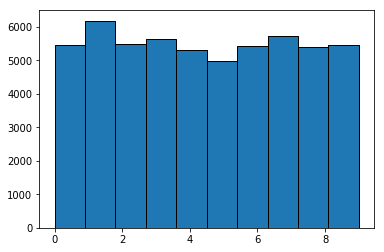

In [57]:
fig, ax = plt.subplots()
label_dist, label_bins = np.histogram(mnist.train.labels, bins = 9)
ax.bar(label_bins[:-1], label_dist, width=np.diff(label_bins), ec="k", align="edge")

plt.show()


In [37]:
list(label_dist)
print(label_bins)
label_dist

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


array([ 5444,  6179,  5470,  5638,  5307,  4987,  5417,  5715, 10843],
      dtype=int64)

A következő lépés a tanítási paraméterek és a neuronháló strukturához a változók inicializálása.

In [1]:
# Parameters
learning_rate = 0.1
num_steps = 1000
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # hidden layer's number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

A neuronháló tanításához létrehozunk egy bemeneti függvényt, ami a korábban letöltött adatbázisból ú.n. batch-eket fog készíteni.

In [3]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.train.images}, y=mnist.train.labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)

A következő kód létrehozza az 1 rejtett réteges hálózatot, lineáris aktivációs függvénnyel.

In [4]:
# Define the neural network
def neural_net(x_dict):
    # TF Estimator input is a dict, in case of multiple inputs
    x = x_dict['images']
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.layers.dense(x, n_hidden_1)
    # Output fully connected layer with a neuron for each class
    out_layer = tf.layers.dense(layer_1, num_classes)
    return out_layer

# Neuronális hálózat
![Neuronális hálózat](http://inf.u-szeged.hu/~papg/bevmely/gyak/kieg/img/neuron_halo_backward_forward_computational_biology.png)

A tanításhoz szükséges dolgok beállítása:
- neuronháló kimenetének kezelése
- loss függvény megadása
- hibametrika választása

In [ ]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    logits = neural_net(features)
    
    # Predictions
    pred_classes = tf.argmax(logits, axis=1)
    pred_probas = tf.nn.softmax(logits)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

A fenti kódok meghívása, estimator létrehozása.

In [ ]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

### Neuronháló tanítása
Megfigyelhető, hogy minden 100. step után közöl információt és 1000 lépésig fut (ezeket feljebb állítottuk be).
Tanítás során célszerű figyelni a loss értékét, az alapján tudjuk beállítani a tanulási paramétereket.

In [ ]:
# Train the Model
model.train(input_fn, steps=num_steps)

Tanítás után kiértékelünk a teszt halmazon.
**Fontos: csak a legjobb modellünket értékeljük ki a teszt halmazon, különben peeking-elünk.**

Peeking (kukucskálás): a teszt halmazon látott teljesítmény alapján optimalizáljuk az algoritmusunk paramétereit,
 ezért nem tudjuk, hogy az milyen jól általánosít.

In [ ]:
# Magic command

%load_ext tensorboard
%tensorboard --logdir=logs

In [ ]:
# Evaluate the Model
# Define the input function for evaluating
input_fn_test = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn_test)

Kiértékelhetünk csak néhány példát is a következő módon:

In [ ]:
# Predict single images
n_images = 4
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn_test_few = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn_test_few))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])

### Feladatok
1. Keressük meg, hogy mely képeken hibázott a háló!
2. Változtassuk a neuronok számát, a batch méretet és a num_step értékét!
3. Adjunk hozzá a neuronhálóhoz további rejtett rétegeket!

### Keras megvalósítás

In [ ]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(256, activation='sigmoid', input_shape=(784,))) # O: activation='relu'
#model.add(Dropout(0.2))
model.add(Dense(256, activation='sigmoid'))
#model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])